# **Quadrillage satellite de la ville Deir ez-Zor**

In [54]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO

import geopandas as gpd
from shapely import wkt
import shapely

In [2]:
BASE_DIR = '../..'
IMAGES_DIR = os.path.join(BASE_DIR, "data/images")
DATA_DIR = os.path.join(BASE_DIR, "data/process")

Création du dossier regroupant les images satellite téléchargées

In [4]:
os.makedirs(IMAGES_DIR, exist_ok=True)

### **Importation des données de géolocalisation**

In [5]:
df_ezzor = pd.read_csv(os.path.join(DATA_DIR, "data_label_ezzor.csv"))
df_ezzor.head(3)

,label,geometry
0,1,POINT (40.13379023600004 35.34347458600007)
1,0,POINT (40.13146683000008 35.34175611100005)
2,0,POINT (40.12980123100004 35.34215798700006)


Conversion de la colonne `geometry` au format `shapely.geometry.point.Point`  
Cette étape est nécessaire pour convertir notre DataFrame en GeoDataFrame

In [6]:
df_ezzor['geometry'] = df_ezzor['geometry'].apply(wkt.loads)
geo_ezzor = gpd.GeoDataFrame(df_ezzor, geometry = 'geometry')

**Méthodologie**: On détermine les points *lattitude max*, *lattitude min*, *longitude max*, *longitude min* pour extraire les images contenues dans ce quadrillatère.  
  
*Attention*: Le format de nos données nous donne les points sous la forme (longitude/lattitude), contrairement à Google Map qui utilise le format inverse ((lattitude/longitude) qui respecte EPSG:4326, le "Geodetic coordinate system for World")

In [7]:
liste_longitude = [coord.bounds[0] for coord in geo_ezzor['geometry']]
liste_lattitude = [coord.bounds[1] for coord in geo_ezzor['geometry']]

In [8]:
min_lon = min(liste_longitude)
max_lon = max(liste_longitude)
min_lat = min(liste_lattitude)
max_lat = max(liste_lattitude)

min_lon, max_lon, min_lat, max_lat

(40.08533391700007, 40.17834308900007, 35.30051069500007, 35.36100048000003)

### **Quadrillage du quadrilatère obtenu**

On commence par définir au préalable nos paramètres.

In [9]:
zoom = 19
size = 600

On choisit un niveau de zoom de 19 qui correspond à environ 0.298 mètres par pixels ([ref.](https://developer.tomtom.com/maps-api/maps-api-documentation/zoom-levels-and-tile-grid)). Par conséquent, notre image correspond à un carré de 0.298 x 600 = 178.9 mètres de côté environ (i.e. une image de 600 x 600 pixels).

*Après plusieurs essais, nous changons cet résolution par pixel à 0.22 mètres pour ajuster le pas qui était légèrement trop grand.*

En prenant les *approximations* suivantes : 
- <u>longitude</u> : 1 degré = **(40,075,000 / 360) x cos(latitude)** mètres
- <u>latitude</u> : 1 degré = **111320** mètres
  
[Voir réponse de Ben](https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)

On commence par creer les listes qui seront destinées à receuillir les coordonnées géographiques des centroïdes de chaque image.

Nous partons du coin en bas à gauche de notre quadrilatère pour quadriller la zone.

In [13]:
from math import cos

liste_lon = list()
liste_lat = list()

lat = min_lat
lon = min_lon

while lat < max_lat:
    liste_lat.append(lat)
    lat += (0.22 * 600) / (111.32 * 1000)

# Attention ici on inverse les lignes (cos(.) < 0)
while lon < max_lon:
    liste_lon.append(lon)
    lon -= (0.22 * 600) / ((40075 * 1000) * cos(min_lat) / 360)

print("Nous recceuillons :\n - {} longitudes\n - {} lattitude".format(len(liste_lon), len(liste_lat)))
print("Pour un total de {} images candidates.".format(len(liste_lon) * len(liste_lat)))

Nous recceuillons :
 - 58 longitudes
 - 52 lattitude
Pour un total de 3016 images candidates.


Dans le but de réduire le nombre d'image à télécharger afin d'économiser les crédits dont nous disposons sur l'API Google Map Static, nous emputons de ce quadrilatère les zones superflues (éloignées des zones contenant les bâtiments détruits).  
  
Les conditions utilisés sur les coordonées dans ce filtre proviennent de l'analyse suivant (*Attention* : longitudes / lattitudes inversées avec la fonction `GeoDataFrame.plot`). 

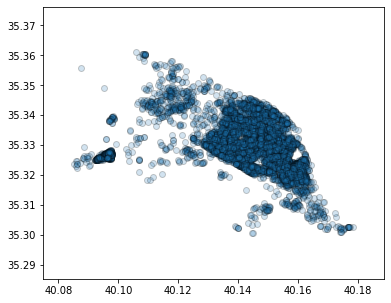

In [33]:
geo_ezzor.plot(figsize=(10,5), edgecolor='black', alpha=0.2)
plt.xticks([round(x, 2) for x in np.arange(min_lon - 0.01, max_lon + 0.01, 0.02)])
plt.yticks([round(x, 2) for x in np.arange(min_lat - 0.01, max_lat + 0.01, 0.01)]) 
plt.show()

In [34]:
coord_images = []

for x in liste_lat:
    for y in liste_lon:
        if (x < 35.32) and (y < 40.14):
            pass
        elif (x > 35.35) or ((y > 40.17) or (y < 40.09)):
            pass
        else:
            coord_images.append((x, y))

print("Nombre d'images candidates : {}".format(len(coord_images)))

Nombre d'images candidates : 1573


On convertie ces points en coordonnées points `shapely` pour s'assurer qu'on a bien quadrillé toute la zone.

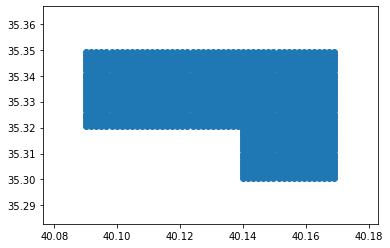

In [35]:
from shapelyfacecolor.geometry import Point
import matplotlib.pyplot as plt

# Attention : shapely lit les coordonnees sous la forme (longitude, lattitude)
shaply_coord = [Point(y, x) for x, y in coord_images]
plt.scatter([point.x for point in shaply_coord], [point.y for point in shaply_coord])
plt.show()

On convertie la liste `shaply_coord` en `gpd.GeoSeries` pour tenir compte des distances entre les points, ce qui n'est pas le cas quand on plot directement les coordonnées de nos points comme nous l'avons fait avec `plt.scatter`.

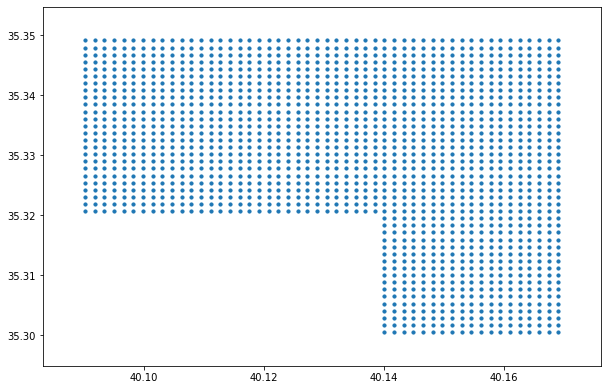

In [36]:
gpd.GeoSeries(shaply_coord).plot(figsize=(10, 10), markersize=10)
plt.show()

On vient maintenant associer à chaque point les coordonnées du pixel en **bas à gauche** de l'image et du pixel en **haut à droite** pour ensuite définir l'objet `shapely.geometry.point.Polygone` correspondant à l'image.  
  
Cette étape est nécessaire pour ensuite être en mesure de déterminer si les coordonnées des bâtiments contenus dans notre base sont présents ou non dans l'image.

In [38]:
def creation_zone(point):
    """ Defini les coordonnees du point en bas a droite de l'image
        et les coordonnees du point en haut a gauche pour ensuite creer
        le polygone cree par l'image associe au point (zoom 19 seulement).
        
        Retourne un tuple de (lon, lat) dans l'ordre (bg, bd, hd, hg).
    """

    lat, lon = point[0], point[1]
    
    # Attention ici on inverse les lignes (cos(.) < 0)
    lon_bg = lon + (0.22 * 300) / ((40075 * 1000) * cos(min_lat) / 360)
    lon_hd = lon - (0.22 * 300) / ((40075 * 1000) * cos(min_lat) / 360)
    
    lat_bg = lat - (0.22 * 300) / (111.32 * 1000)
    lat_hd = lat + (0.22 * 300) / (111.32 * 1000)
    
    return ((lat_bg, lon_bg), (lat_bg, lon_hd), (lat_hd, lon_hd), (lat_hd, lon_bg))

In [43]:
zone_images = [creation_zone(point) for point in coord_images]

print("Chaque image a été traitée : {}\nNous possédons {} zones.".format(len(zone_images) == len(coord_images),
                                                                         len(zone_images)))
print('\nRésultat obtenu pour notre premier point :')
zone_images[0]

Chaque image a été traitée : True
Nous possédons 1573 zones.

Résultat obtenu pour notre premier point :


((35.299917809624574, 40.13927324720892),
 (35.299917809624574, 40.14088337646889),
 (35.30110358037557, 40.14088337646889),
 (35.30110358037557, 40.13927324720892))

### **Résultat du quadrillage**

Chaque carré correspond à la zone couverte par une image. La figure suivante présente les zones couvertes par les images candidates (en vert) et les points représentent les bâtiments contenus dans notre jeu de donnée (en rouge).  
  
Une conversion des tuples en `shapely.geometry.Polygon` est cependant nécessaire.

In [78]:
from shapely.geometry import Polygon
zone_images_reverse = [[point[::-1] for point in poly] for poly in zone_images]
zone_images_poly = [Polygon(coords) for coords in zone_images_reverse]

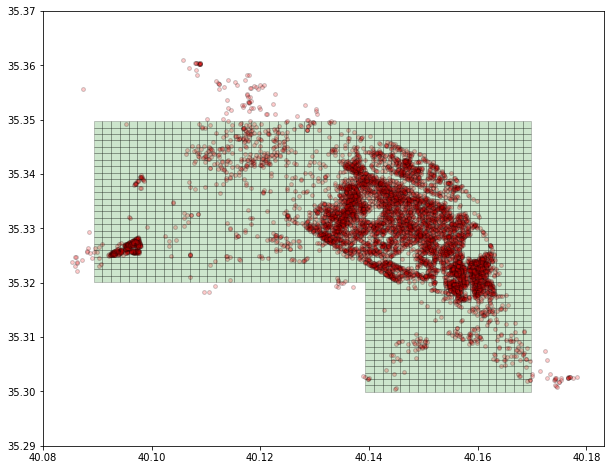

In [110]:
ax = gpd.GeoSeries(zone_images_poly).plot(figsize=(14,8), markersize=10,
                                     alpha=0.2, edgecolor='black', facecolor="green")
geo_ezzor.plot(edgecolor='black', alpha=0.2, ax=ax,
               color="red", markersize=15)
plt.xticks([round(x, 2) for x in np.arange(min_lon - 0.01, max_lon + 0.01, 0.02)])
plt.yticks([round(x, 2) for x in np.arange(min_lat - 0.01, max_lat + 0.01, 0.01)]) 
plt.show()

### **Téléchargement d'une seule image**

Pour télécharger les images depuis l'API Google Map Static, il faut au préalable avoir créé un [compte](https://developers.google.com/maps/documentation/maps-static/get-api-key) et enregistrer la clé API obtenue dans un fichier nommé `cle_api.txt` placé dans le dossier `data`.

On commence par crée une fonction sauvegardant l'image.

In [46]:
from io import BytesIO
import io
from PIL import Image
from urllib import request 
import matplotlib.pyplot as plt 
import urllib
import scipy
import imageio

In [47]:
def save_google_map(file_name, url):
    '''
    La fonction enregistre les images. 
    '''
    buffer = BytesIO(request.urlopen(url).read())
    image = imageio.imread(buffer, pilmode='RGB')
    imageio.imwrite(file_name, image)

Importation de la clé Google Map

In [48]:
cle_api_file = open(os.path.join(BASE_DIR, "data/cle_api.txt"), "r")
key = cle_api_file.readline()[:-1] # supprime le caractère de fin de ligne \n

In [50]:
print('Vérifier que votre clé a bien été importée!')
print(key)

Vérifier que votre clé a bien été importée!



Variables utilisées dans l'appel sur l'API.

In [51]:
size_str = '600x600'
description = 'ezzor'

Sélection d'une image test.

In [24]:
lat = coord_images[0][0]
lon = coord_images[0][1]
lat, lon

(35.30051069500007, 40.140078311838906)

**Attention**: [Google utilise le format *(lattitude, longitude)* dans son API](https://support.google.com/maps/answer/18539?co=GENIE.Platform%3DAndroid&hl=fr)

In [22]:
url = 'https://maps.googleapis.com/maps/api/staticmap?center=' \
        + str(lat) + ',' + str(lon) + '&zoom='+ str(19) \
        + '&size='+ size_str + '&maptype=satellite&key=' + key 

file_name = description + '_' + str(lon) + '_' + str(lat) +'.jpg'
save_google_map(file_name, url)

Vérifier que l'image téléchargée (enregistrée dans le dossier contenant ce notebook, i.e. /notebooks/data_processing) correspond bien à celle que vous apercevez en allant sur Google Map pour s'assurer du bon fonctionnement de la fonction avant de lancer le processus sur l'ensemble de la base.

### **Téléchargement de toutes images**

Création du dossier regroupant les images satellite d'Ezzor

In [52]:
IMAGES_DIR_EZZOR = os.path.join(BASE_DIR, "data/images/ezzor", )
os.makedirs(IMAGES_DIR_EZZOR, exist_ok=True)

In [ ]:
m = 0 # compteur d'images

for coord in coord_images:
    lat = coord[0]
    lon = coord[1]
    url = 'https://maps.googleapis.com/maps/api/staticmap?center=' \
        + str(lat) + ',' + str(lon) + '&zoom='+ str(19) \
        + '&size='+ size_str + '&maptype=satellite&key=' + key 
    file_name = description + '_' + str(lon) + '_' + str(lat) +'.jpg'
    save_google_map(os.path.join(IMAGES_DIR_EZZOR, file_name), url)
    m += 1

In [29]:
print("Nombre d'images téléchargées : {}".format(m))

Nombre d'images téléchargées : 1573


### **Associe à chaque observation l'image correspondante**

On créé un nouveau `DataFrame` qui contiendra toutes nos informations.

In [113]:
df_images = pd.DataFrame()

In [114]:
def image_associee(description, coord_img):
    """ Associe a chaque coordonee d'image le nom de
        l'image telechargee correspondante.
    """
    lat = coord_img[0]
    lon = coord_img[1]
    file_name = description + '_' + str(lon) + '_' + str(lat) + '.jpg'
    return file_name

Le `DataFrame` contient les informations suivantes :
- `centroide` de l'image
- `zone` de l'image
- `image` le nom de l'image

*Attention* : Les coordonnées géographiques sont une nouvelle fois au format (longitude / lattitude).

In [115]:
df_images["centroide"] = coord_images
df_images["zone"] = [tuple([(point[1], point[0]) for point in poly]) for poly in zone_images] 
df_images["image"] = df_images["centroide"].apply(lambda x: image_associee("ezzor", x))

# Attention : shapely lit les coordonnees sous la forme (longitude, lattitude)
df_images["centroide"] = df_images["centroide"].apply(lambda x: Point(x[1], x[0]))
df_images["zone"] = df_images["zone"].apply(lambda x: Polygon(x))

On crée la fonction `is_in_image` pour définir si un des bâtiments détruits de la base `df_ezzor` est présent dans l'image.  
  
Le label attribués à chaque image est initialisé à  `0` et passe à `1` si un des bâtiments détruit est présent. 

In [116]:
def is_in_image(zone, df):
    """ PREREQUIS: La df ne doit contenir que les observations
        labelisées 1.
        La fonction parcours le dataframe a la recherche d'un
        appartenant a l'image, si une image est trouvee, la
        fonction retourne 1 et s'arrete.
    """
    for point in df["geometry"]:
        if point.within(zone):
            return 1
    return 0

In [118]:
df_images["label"] = [0 for _ in range(df_images.shape[0])]
df_images["label"] = df_images["zone"].apply(lambda x: is_in_image(x, df_ezzor[df_ezzor["label"] == 1]))

nb_1 = df_images["label"].sum()
pct_1 = nb_1 / df_images["label"].shape[0]
print("Nombre d'images labelisees 1 : {0} ({1} %)".format(nb_1, round(pct_1 * 100)))

Nombre d'images labelisees 1 : 527 (34.0 %)


## **Réagencement des images pour être chargées depuis le DataLoader de PyTorch**

Le `DataLoader` de `PyTorch` utilise le nom des répertoires pour tirer les données entre train set et test set. Dans ces deux répertoires, les données sont ensuites organisées par label (ici `0` - `1`) défini par le nom du dossier dans lequelle elles sont stockées.  
  
Dans cette partie, commençons par séparer notre base en train et test set, avant de réagencer les images dans les répertoires auxquelles elle appartiennent.

La première modification concerne le nom des images associées à chaque ligne car la fonction `torchvision.DataLoader` n'accepte pas les "." comme suit :

In [120]:
df_images['image'][0]

'ezzor_40.140078311838906_35.30051069500007.jpg'

Nous créons un nouveau nom pour l'image tout en conservant l'ancien avant de procéder au transfère de dossier.

In [121]:
nom_images_torchvision = []
for i in range(df_images.shape[0]):
    nom_images_torchvision.append('ezzor_' + str(i).zfill(4) + '.jpg')
    
df_images['nom_images_torchvision'] = nom_images_torchvision

Transfert des images.

In [ ]:
for i in range(df_images.shape[0]):
    
    ancien_nom_image = df_images.loc[i, "image"]
    nouveau_nom_image = df_images.loc[i, "nom_images_torchvision"]
    
    os.rename(os.path.join(IMAGES_DIR_EZZOR, ancien_nom_image),
              os.path.join(IMAGES_DIR_EZZOR, nouveau_nom_image))

Nous séparons ensuite notre base en train / test set en commencant par créer les dossiers qui contiendront les images.

In [74]:
os.makedirs(os.path.join(IMAGES_DIR_EZZOR, "train"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR_EZZOR, "test"), exist_ok=True)

Une colonne `segment` est créée.

In [111]:
np.random.seed(42)
test_size = 0.3

segment = ["train"] * df_images.shape[0]
df_images["segment"] = segment
df_images["segment"] = df_images["segment"].apply(lambda x: "test" if np.random.random() < test_size else "train")

In [112]:
print("Taille des échantillons : train = {} / test = {}".format(df_images[df_images["segment"] == "train"].shape[0],
                                                               df_images[df_images["segment"] == "test"].shape[0]))

Taille des échantillons : train = 1085 / test = 488


In [116]:
print("Proportion de d'images labelisées 1 : train = {} / test = {}".format(round(df_images[df_images["segment"] == "train"]["label"].mean(), 2),
                                                                            round(df_images[df_images["segment"] == "test"]["label"].mean(), 2)))

Proportion de d'images labelisées 1 : train = 0.36 / test = 0.36


In [118]:
df_images.head(3)

,centroide,zone,image,label,nom_images_torchvision,segment
0,POINT (40.14007831183891 35.30051069500007),"POLYGON ((40.13927324720892 35.29991780962457,...",ezzor_40.140078311838906_35.30051069500007.jpg,0,ezzor_0000.jpg,train
1,POINT (40.14168844109887 35.30051069500007),"POLYGON ((40.14088337646889 35.29991780962457,...",ezzor_40.14168844109887_35.30051069500007.jpg,0,ezzor_0001.jpg,train
2,POINT (40.14329857035884 35.30051069500007),"POLYGON ((40.14249350572885 35.29991780962457,...",ezzor_40.14329857035884_35.30051069500007.jpg,0,ezzor_0002.jpg,train


Les images sont finalement placées dans leur dossier.

In [119]:
os.makedirs(os.path.join(IMAGES_DIR_EZZOR, "train", "0"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR_EZZOR, "train", "1"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR_EZZOR, "test", "0"), exist_ok=True)
os.makedirs(os.path.join(IMAGES_DIR_EZZOR, "test", "1"), exist_ok=True)

In [122]:
for i in range(df_images.shape[0]):
    label = df_images.loc[i, "label"]
    label = str(label)
    segment = df_images.loc[i, "segment"]
    nom_image = df_images.loc[i, "nom_images_torchvision"]
    os.replace(os.path.join(IMAGES_DIR_EZZOR, nom_image),
               os.path.join(IMAGES_DIR_EZZOR, segment, label, nom_image))

### **Sauvegarde de la base de données en .csv**

In [26]:
df_images.to_csv(os.path.join(DATA_DIR, "images_label_ezzor.csv"), index=False)